In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pymc as mc
import numpy as np

import h5py

from vpfits import *

vpfits.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/disk2/sapple/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/disk2/sapple/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/disk2/sapple/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/disk2/sapple/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/disk2/sapple/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/disk2/sa

In [2]:
line = 1036.

# use hydrogen spectrum for this as it is faster
data = h5py.File('data/spectrum_pygad_CII1036.h5', 'r')

wavelength = data['wavelength'][:]
flux = data['flux'][:]
noise = data['noise'][:]
taus = data['tau'][:]

nu = constants['c']['value'] / wavelength 

In [3]:
# Identify regions in the spectrum to fit

min_region_width = 2
regions, region_pixels = compute_detection_regions(wavelength, taus, flux, noise,
                                          min_region_width=min_region_width)

Computing detection regions...
Found 4 detection regions.


Setting initial number of lines to: 1
Old BIC value of -6.65 is greater than the current -16.45.
Increasing the number of lines to: 3
Old BIC value of -16.45 is greater than the current -78.23.
Increasing the number of lines to: 4
BIC increased with increasing the line number, stopping.
Final n=3.


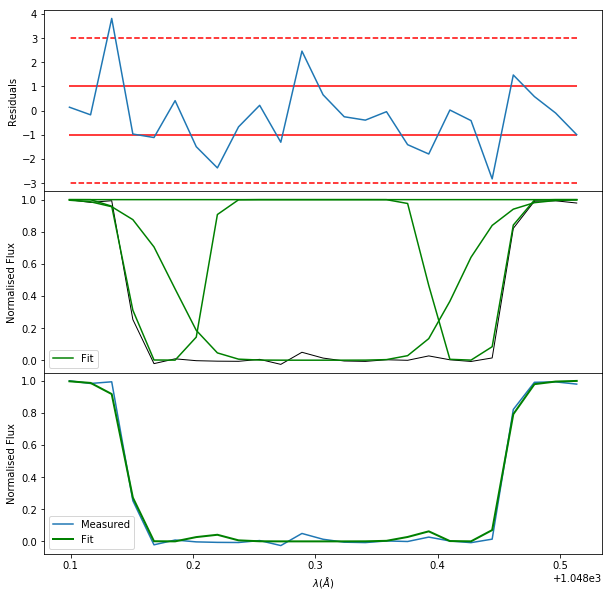

Reduced chi squared is 5.94762783172
Setting initial number of lines to: 1
Old BIC value of -5.48 is greater than the current -14.18.
Increasing the number of lines to: 3
Old BIC value of -14.18 is greater than the current -74.33.
Increasing the number of lines to: 4
Old BIC value of -74.33 is greater than the current -83.08.
Increasing the number of lines to: 5
Old BIC value of -83.08 is greater than the current -90.45.
Increasing the number of lines to: 6
BIC increased with increasing the line number, stopping.
Final n=5.


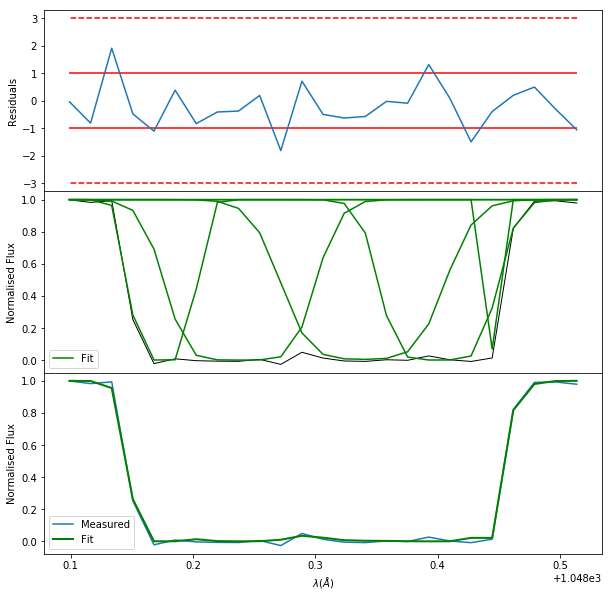

Reduced chi squared is 1.73755310556
Setting initial number of lines to: 1
Old BIC value of -7.45 is greater than the current -16.84.
Increasing the number of lines to: 3
Old BIC value of -16.84 is greater than the current -64.39.
Increasing the number of lines to: 4
Old BIC value of -64.39 is greater than the current -76.99.
Increasing the number of lines to: 5
BIC increased with increasing the line number, stopping.
Final n=4.


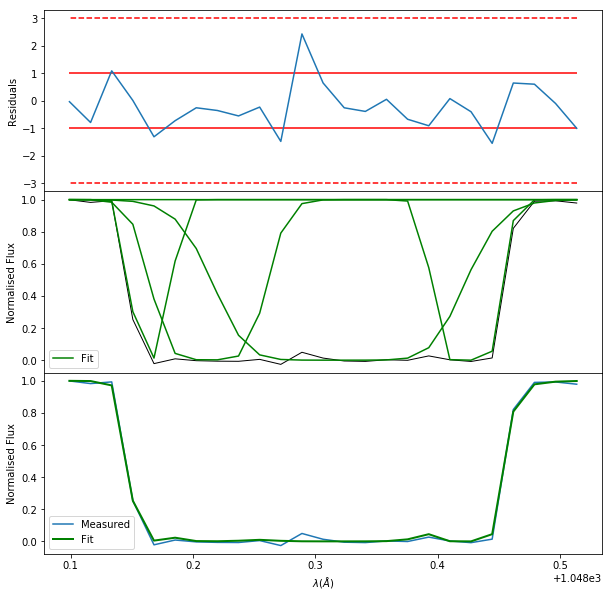

Reduced chi squared is 2.05480825439
Setting initial number of lines to: 1
Old BIC value of -8.47 is greater than the current -11.06.
Increasing the number of lines to: 3
Old BIC value of -11.06 is greater than the current -63.99.
Increasing the number of lines to: 4
Old BIC value of -63.99 is greater than the current -99.08.
Increasing the number of lines to: 5
BIC increased with increasing the line number, stopping.
Final n=4.


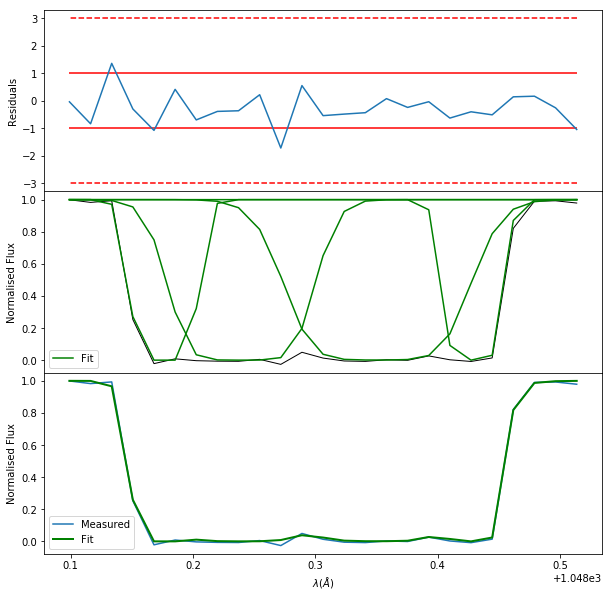

Reduced chi squared is 1.17472193691
Setting initial number of lines to: 1
Old BIC value of -25.70 is greater than the current -46.03.
Increasing the number of lines to: 3
Old BIC value of -46.03 is greater than the current -180.68.
Increasing the number of lines to: 4
Old BIC value of -180.68 is greater than the current -194.97.
Reduced Chi squared is less than 1.5
Final n=4


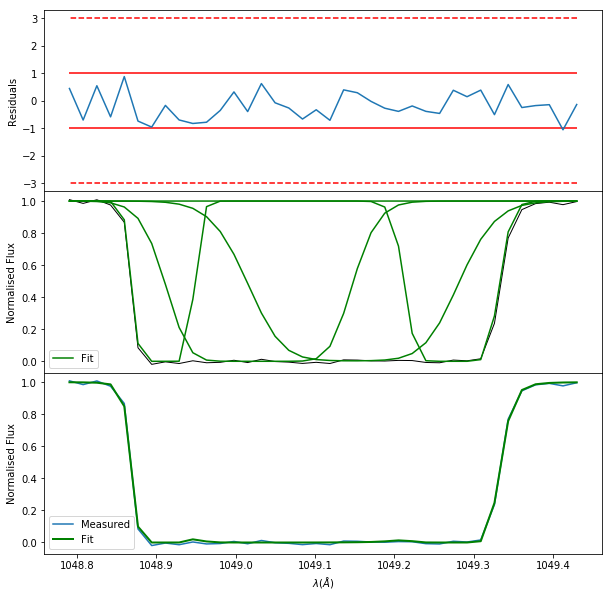

Reduced chi squared is 0.825158249365
Setting initial number of lines to: 1
Old BIC value of -10.88 is greater than the current -27.45.
Increasing the number of lines to: 3
Old BIC value of -27.45 is greater than the current -60.75.
Increasing the number of lines to: 4
Old BIC value of -60.75 is greater than the current -63.70.
Reduced Chi squared is less than 1.5
Final n=4


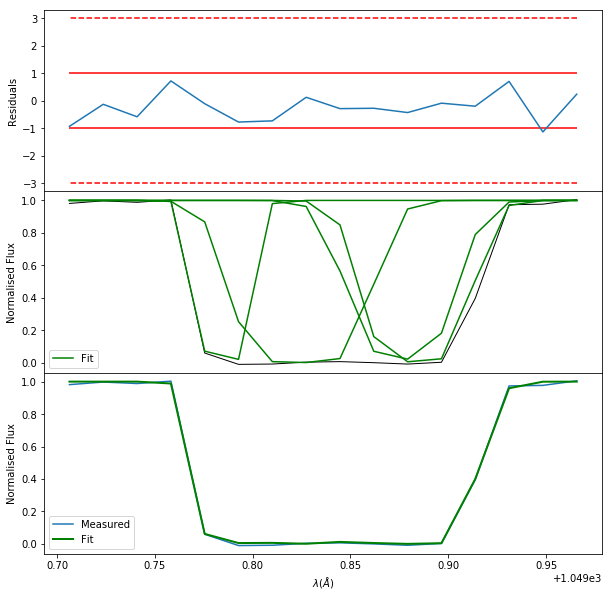

Reduced chi squared is 0.733542546304
Setting initial number of lines to: 1
BIC increased with increasing the line number, stopping.
Final n=1.


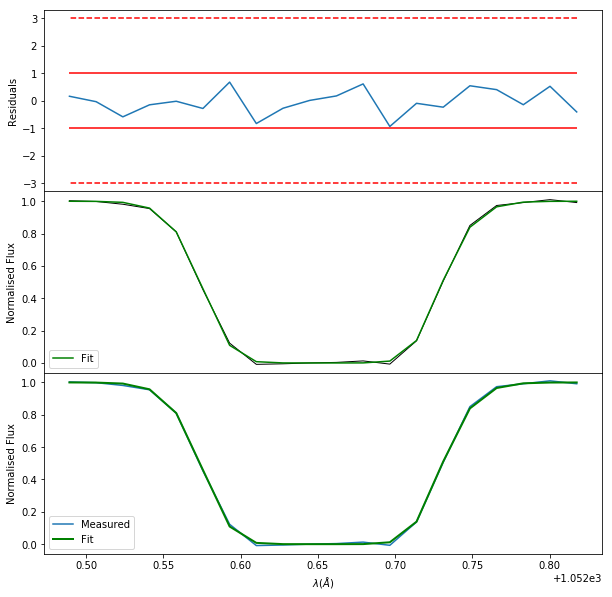

Reduced chi squared is 0.689840503004


In [4]:
wavelength_array = wavelength
frequency_array = nu
tau_array = taus
flux_array = flux
noise_array = noise

frequency_array = constants['c']['value'] / (wavelength_array*1.e-10)

flux_model = {'total': np.ones(len(flux_array)), 'chi_squared': np.zeros(len(regions))}

j = 0

for start, end in region_pixels[0:]:
    fluxes = np.flip(flux_array[start:end], 0)
    noises = np.flip(noise_array[start:end], 0)
    waves = np.flip(wavelength_array[start:end], 0)
    nu = np.flip(frequency_array[start:end], 0)
    
    for _ in range(10):
        # make initial guess for number of lines in a region
        n = estimate_n(fluxes)

        # number of degrees of freedom = number of data points + number of parameters
        freedom = len(fluxes) + 3*n

        # fit the region by minimising BIC and chi squared
        fit = region_fit(nu, fluxes, n, noises, freedom, voigt=False, chi_limit=1.5)

        # evaluate overall chi squared
        n = len(fit.estimated_profiles)
        freedom = len(fluxes) + 3*n

        fit.plot(waves, fluxes, n=n, start_pix=start, end_pix=end)

        flux_model['chi_squared'][j] = fit.ReducedChisquared(fluxes, fit.total.value, noises, freedom)

        print 'Reduced chi squared is {}'.format(flux_model['chi_squared'][j])

        #if chi squared is sufficiently small, stop there. If not, repeat the region fitting
        if flux_model['chi_squared'][j] < 1.5:
            break

    j += 1


In [5]:
params, flux_model = fit_spectrum(wavelength, noise, taus, line, chi_limit=1.5)

Computing detection regions...
Found 4 detection regions.
Setting initial number of lines to: 1
BIC increased with increasing the line number, stopping.
Final n=1.
fit chi squared: 233.12476588035946
Reduced chi squared is 233.12476588
Setting initial number of lines to: 1
Old BIC value of -7.38 is greater than the current -14.21.
Increasing the number of lines to: 3
Old BIC value of -14.21 is greater than the current -59.04.
Increasing the number of lines to: 4
Old BIC value of -59.04 is greater than the current -125.22.
Reduced Chi squared is less than 1.5
Final n=4
fit chi squared: 0.6485269055495613
Reduced chi squared is 0.490777117713
Setting initial number of lines to: 1
Old BIC value of -25.01 is greater than the current -48.06.
Increasing the number of lines to: 3
Old BIC value of -48.06 is greater than the current -190.25.
Reduced Chi squared is less than 1.5
Final n=3
fit chi squared: 1.533882199399756
Reduced chi squared is 1.33806745054
Setting initial number of lines to: 

In [6]:
plot_spectrum(wavelength, flux, flux_model, region_pixels, '/disk2/sapple/VAMP/plots/')

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>